<a href="https://colab.research.google.com/github/kimdonggyufive/OpenReposit/blob/main/3_buston.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Boston housing - linear regression

In [ ]:
import keras
keras.__version__

'2.4.3'

In [ ]:
import numpy as np
import tensorflow as tf

np.random.seed(777)
tf.random.set_seed(777)

In [ ]:
from tensorflow.keras.datasets import boston_housing
(train_data,train_targets),(test_data,test_targets)=boston_housing.load_data()

57344/57026 [==============================] - 0s 0us/step


In [ ]:
train_data.shape

(404, 13)

In [ ]:
test_data.shape

(102, 13)

In [ ]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

# Data preparation

In [ ]:
mean=train_data.mean(axis=0)
train_data-=mean
std=train_data.std(axis=0)
train_data/=std

test_data-=mean
test_data/=std

# Modeling

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
def build_model():
  model=Sequential()
  model.add(Dense(64,activation='relu',input_shape=(train_data.shape[1],)))
  model.add(Dense(64,activation='relu'))
  model.add(Dense(1))
  model.compile(optimizer='adam',loss='mse',metrics=['mae'])
  return model

# Kfold cross validation

In [ ]:
k=4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

import time
for i in range(k):
    print('처리중인 폴드 #', i, time.strftime('%c',time.localtime(time.time())))
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    history=model.fit(partial_train_data, partial_train_targets,
        epochs=num_epochs, batch_size=64, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets)
    all_scores.append(val_mae)

처리중인 폴드 # 0 Wed Aug 19 07:26:08 2020
4/4 [==============================] - 0s 2ms/step - loss: 9.3130 - mae: 2.1421
처리중인 폴드 # 1 Wed Aug 19 07:26:09 2020
4/4 [==============================] - 0s 2ms/step - loss: 13.1975 - mae: 2.8165
처리중인 폴드 # 2 Wed Aug 19 07:26:11 2020
4/4 [==============================] - 0s 2ms/step - loss: 16.0145 - mae: 2.6469
처리중인 폴드 # 3 Wed Aug 19 07:26:12 2020
4/4 [==============================] - 0s 2ms/step - loss: 13.4608 - mae: 2.6327


In [ ]:
all_scores

[2.1420555114746094, 2.8164761066436768, 2.6469333171844482, 2.6326744556427]

In [ ]:
np.mean(all_scores)

2.5595348477363586

# Epoch을 늘려서 Train

In [ ]:
from keras import backend as K

K.clear_session()

In [ ]:
k=4
num_epochs = 500
all_mae_histories=[]

#import time
for i in range(k):
  print('처리중인 폴드 #', i, time.strftime('%c',time.localtime(time.time())))
  # 검증 데이터 준비: k번째 분할
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

  # 훈련 데이터 준비: 다른 분할 전체
  partial_train_data = np.concatenate(
      [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
      axis=0)
  partial_train_targets = np.concatenate(
      [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
      axis=0)

  model = build_model()
  history=model.fit(partial_train_data, partial_train_targets,
      validation_data=(val_data, val_targets),
      epochs=num_epochs, batch_size=64, verbose=0)
  mae_history=history.history['val_mae']
  all_mae_histories.append(mae_history)

처리중인 폴드 # 0 Wed Aug 19 07:26:13 2020
처리중인 폴드 # 1 Wed Aug 19 07:26:22 2020
처리중인 폴드 # 2 Wed Aug 19 07:26:31 2020
처리중인 폴드 # 3 Wed Aug 19 07:26:41 2020


In [ ]:
[i for i in range(10)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
average_mae_history=[np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
average_mae_history

[21.93287706375122,
 21.437023162841797,
 20.90539026260376,
 20.323078632354736,
 19.658235549926758,
 18.88795566558838,
 18.00573992729187,
 17.000810146331787,
 15.858413219451904,
 14.588934659957886,
 13.224184274673462,
 11.78148865699768,
 10.34542453289032,
 9.073756456375122,
 7.992378830909729,
 7.108149886131287,
 6.451195240020752,
 5.959415912628174,
 5.592790067195892,
 5.298392057418823,
 5.034512400627136,
 4.793275415897369,
 4.566816031932831,
 4.375003516674042,
 4.214923560619354,
 4.070713698863983,
 3.939462661743164,
 3.8367998600006104,
 3.74614280462265,
 3.6719528436660767,
 3.6018115282058716,
 3.5463184118270874,
 3.494559407234192,
 3.4475642442703247,
 3.401675224304199,
 3.3603833317756653,
 3.3233402967453003,
 3.289446234703064,
 3.260637044906616,
 3.231210470199585,
 3.2099169492721558,
 3.1803431510925293,
 3.165925681591034,
 3.1423307061195374,
 3.1207547187805176,
 3.0925099849700928,
 3.080615222454071,
 3.058790922164917,
 3.0345041155815125,
 

In [ ]:
model.evaluate(test_data,test_targets)

4/4 [==============================] - 0s 2ms/step - loss: 20.5441 - mae: 2.9145


[20.544103622436523, 2.914531707763672]

# 시각화

In [ ]:
import matplotlib.pyplot as plt

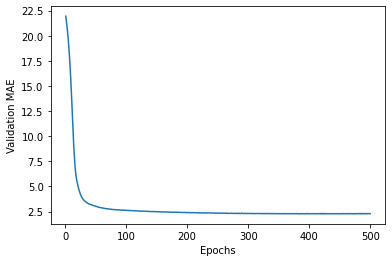

In [ ]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [ ]:
def smooth_curve(points, factor = 0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1. - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

In [ ]:
smooth_mae_history=smooth_curve(average_mae_history[10:])

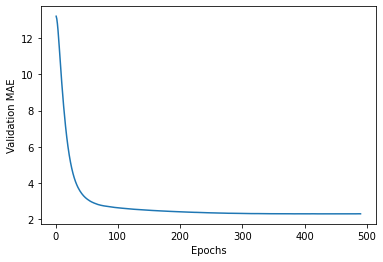

In [ ]:
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [ ]:
model=build_model()
model.fit(train_data, train_targets,
          epochs=200, batch_size=16, verbose=1)

Epoch 1/200
26/26 [==============================] - 0s 1ms/step - loss: 579.2088 - mae: 22.2147
Epoch 2/200
26/26 [==============================] - 0s 1ms/step - loss: 482.8746 - mae: 20.1154
Epoch 3/200
26/26 [==============================] - 0s 1ms/step - loss: 327.5322 - mae: 16.1153
Epoch 4/200
26/26 [==============================] - 0s 1ms/step - loss: 139.9832 - mae: 9.3958
Epoch 5/200
26/26 [==============================] - 0s 1ms/step - loss: 59.7730 - mae: 5.8731
Epoch 6/200
26/26 [==============================] - 0s 1ms/step - loss: 38.0792 - mae: 4.5216
Epoch 7/200
26/26 [==============================] - 0s 997us/step - loss: 27.8406 - mae: 3.8139
Epoch 8/200
26/26 [==============================] - 0s 1ms/step - loss: 24.0066 - mae: 3.4676
Epoch 9/200
26/26 [==============================] - 0s 1ms/step - loss: 21.8676 - mae: 3.3618
Epoch 10/200
26/26 [==============================] - 0s 1ms/step - loss: 20.2139 - mae: 3.1789
Epoch 11/200
26/26 [====================

In [ ]:
test_mse_score, test_mae_score=model.evaluate(test_data,test_targets)
test_mae_score

4/4 [==============================] - 0s 2ms/step - loss: 13.1222 - mae: 2.4849


2.484934091567993